In [ ]:
!pip install torchvision --quiet
!pip install scikit-learn --quiet

In [ ]:
!pip install tqdm seaborn --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import os

In [ ]:
from torchvision.datasets import Flowers102

# Transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Add normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Add normalization
    ])
}

# Load dataset
train_set = Flowers102(root='.', split='train', download=True, transform=transform['train'])
val_set = Flowers102(root='.', split='val', download=True, transform=transform['val'])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

print(f"Classes: {len(train_set.classes)}")

Classes: 102


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model

# Train the simple CNN
model = train_model(model, {'train': train_loader}, criterion, optimizer, num_epochs=5)

Epoch 1/5
Train Loss: 5.0950, Accuracy: 0.0127
Epoch 2/5
Train Loss: 4.6112, Accuracy: 0.0078
Epoch 3/5
Train Loss: 4.4243, Accuracy: 0.0294
Epoch 4/5
Train Loss: 4.0116, Accuracy: 0.0804
Epoch 5/5
Train Loss: 3.3420, Accuracy: 0.1745
Training complete in 0m 38s


In [ ]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False  # freeze pretrained layers

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 102)  # 102 flower classes

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.fc.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [ ]:
# Train only the last layer (fine-tuning)
model_ft = train_model(model_ft, {'train': train_loader}, criterion, optimizer, num_epochs=5)

Epoch 1/5
Train Loss: 4.5760, Accuracy: 0.0627
Epoch 2/5
Train Loss: 3.2185, Accuracy: 0.4373
Epoch 3/5
Train Loss: 2.3246, Accuracy: 0.7029
Epoch 4/5
Train Loss: 1.7005, Accuracy: 0.8314
Epoch 5/5
Train Loss: 1.2439, Accuracy: 0.9039
Training complete in 0m 32s


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    acc = accuracy_score(labels_all, preds)
    return acc

# Evaluate
simple_cnn_acc = evaluate_model(model, val_loader)
resnet_acc = evaluate_model(model_ft, val_loader)

print(f'Simple CNN Accuracy: {simple_cnn_acc:.4f}')
print(f'ResNet18 Accuracy: {resnet_acc:.4f}')

Simple CNN Accuracy: 0.1225
ResNet18 Accuracy: 0.7647


Let's unfreeze some of the later layers of the ResNet18 model for further fine-tuning. We will also set up different learning rates for the unfrozen layers and the final classification layer.

In [ ]:
# Load a fresh pretrained ResNet18 model
model_ft_optimized = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model_ft_optimized.parameters():
    param.requires_grad = False

# Unfreeze the last few layers (e.g., the last two blocks)
# You might need to experiment with which layers to unfreeze
unfreeze_layers = ['layer4', 'layer3', 'layer2', 'fc'] # Example: Unfreeze layer4, layer3, layer2 and the fc layer

for name, module in model_ft_optimized.named_modules():
    if any(unfreeze_name in name for unfreeze_name in unfreeze_layers):
        for param in module.parameters():
            param.requires_grad = True

# Modify the final fully connected layer for 102 classes
num_ftrs_optimized = model_ft_optimized.fc.in_features
model_ft_optimized.fc = nn.Linear(num_ftrs_optimized, 102)

model_ft_optimized = model_ft_optimized.to(device)

# Define optimizer with different learning rates
optimizer_optimized = optim.Adam([
    {'params': model_ft_optimized.fc.parameters(), 'lr': 0.001}, # Higher learning rate for the new layer
    {'params': [param for name, param in model_ft_optimized.named_parameters() if any(unfreeze_name in name for unfreeze_name in unfreeze_layers) and 'fc' not in name], 'lr': 0.0001} # Lower learning rate for unfrozen layers
])

criterion_optimized = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now, let's train the optimized ResNet18 model with the updated optimizer and train for a few more epochs. We will also modify the `train_model` function slightly to show training progress more frequently within each epoch.

In [ ]:
def train_model_optimized(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    train_loss_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (i + 1) % 100 == 0: # Print every 100 batches
                print(f'  Batch {i+1}, Loss: {loss.item():.4f}')


        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, train_loss_history, train_acc_history

# Train the optimized ResNet18 model
model_ft_optimized, train_loss_optimized, train_acc_optimized = train_model_optimized(
    model_ft_optimized, {'train': train_loader}, criterion_optimized, optimizer_optimized, num_epochs=10 # Increased epochs
)

Epoch 1/10
Train Loss: 4.4040, Accuracy: 0.0902
Epoch 2/10
Train Loss: 2.7101, Accuracy: 0.4794
Epoch 3/10
Train Loss: 1.6168, Accuracy: 0.7324
Epoch 4/10
Train Loss: 1.0778, Accuracy: 0.8137
Epoch 5/10
Train Loss: 0.6995, Accuracy: 0.8931
Epoch 6/10
Train Loss: 0.5259, Accuracy: 0.9206
Epoch 7/10
Train Loss: 0.3979, Accuracy: 0.9412
Epoch 8/10
Train Loss: 0.3193, Accuracy: 0.9529
Epoch 9/10
Train Loss: 0.2251, Accuracy: 0.9745
Epoch 10/10
Train Loss: 0.1701, Accuracy: 0.9833
Training complete in 2m 5s


Now let's evaluate the optimized ResNet18 model and compare its accuracy and training time with the simple CNN and the previously fine-tuned ResNet18.

In [ ]:
# Evaluate the optimized ResNet18
resnet_optimized_acc = evaluate_model(model_ft_optimized, val_loader)

print(f'Simple CNN Accuracy: {simple_cnn_acc:.4f}')
print(f'Previously fine-tuned ResNet18 Accuracy: {resnet_acc:.4f}')
print(f'Optimized ResNet18 Accuracy: {resnet_optimized_acc:.4f}')

# Note: To compare training times accurately, you would need to record the time for each training run separately.
# The printed output from the training functions provides the time taken for each training session.

Simple CNN Accuracy: 0.1225
Previously fine-tuned ResNet18 Accuracy: 0.7647
Optimized ResNet18 Accuracy: 0.8637


Let's train the optimized ResNet18 model with the updated data augmentation.

In [ ]:
# Train the optimized ResNet18 model with updated data augmentation
model_ft_optimized, train_loss_optimized, train_acc_optimized = train_model_optimized(
    model_ft_optimized, {'train': train_loader}, criterion_optimized, optimizer_optimized, num_epochs=10 # Keeping the increased epochs
)

Epoch 1/10
Train Loss: 4.2727, Accuracy: 0.1588
Epoch 2/10
Train Loss: 2.0049, Accuracy: 0.6941
Epoch 3/10
Train Loss: 0.9473, Accuracy: 0.8882
Epoch 4/10
Train Loss: 0.4587, Accuracy: 0.9598
Epoch 5/10
Train Loss: 0.2403, Accuracy: 0.9882
Epoch 6/10
Train Loss: 0.1393, Accuracy: 0.9951
Epoch 7/10
Train Loss: 0.0961, Accuracy: 0.9980
Epoch 8/10
Train Loss: 0.0725, Accuracy: 0.9990
Epoch 9/10
Train Loss: 0.0506, Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0420, Accuracy: 1.0000
Training complete in 2m 17s


Now let's evaluate the optimized ResNet18 model with the updated data augmentation and compare its accuracy.

In [ ]:
# Evaluate the optimized ResNet18
resnet_optimized_acc = evaluate_model(model_ft_optimized, val_loader)

print(f'Simple CNN Accuracy: {simple_cnn_acc:.4f}')
print(f'Previously fine-tuned ResNet18 Accuracy: {resnet_acc:.4f}')
print(f'Optimized ResNet18 Accuracy (with more unfreezing and data augmentation): {resnet_optimized_acc:.4f}')

Simple CNN Accuracy: 0.1225
Previously fine-tuned ResNet18 Accuracy: 0.7647
Optimized ResNet18 Accuracy (with more unfreezing and data augmentation): 0.9020


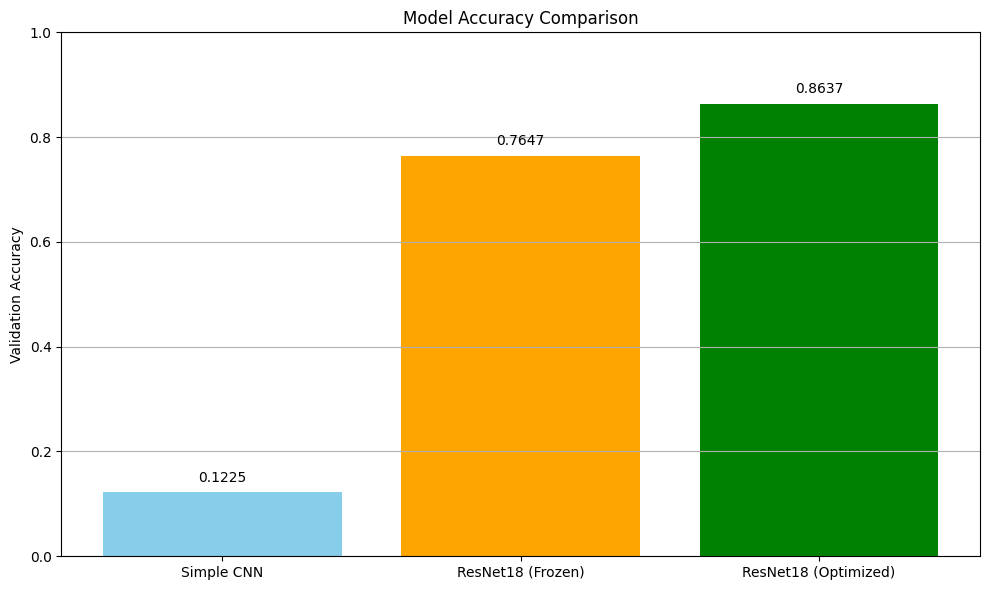

In [5]:
import matplotlib.pyplot as plt

# Hardcoded accuracy values
accuracies = [0.1225, 0.7647, 0.8637]
model_names = ['Simple CNN', 'ResNet18 (Frozen)', 'ResNet18 (Optimized)']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylabel('Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

# Annotate bars
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{acc:.4f}", ha='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()
